RETAIL DEMAND FORECASTING SYSTEM

Dataset loaded: 73100 records
Date range: 2022-01-01 00:00:00 to 2024-01-01 00:00:00
Number of products: 20

Selected Product ID: P0016
Total sales: 508472 units

Training set: 584 days
Test set: 147 days

Training Prophet model...


12:20:26 - cmdstanpy - INFO - Chain [1] start processing
12:20:26 - cmdstanpy - INFO - Chain [1] done processing


✓ Model trained successfully

MODEL EVALUATION METRICS
MAE  (Mean Absolute Error):      152.39 units
RMSE (Root Mean Squared Error):  199.58 units
MAPE (Mean Absolute % Error):    32.75%
⚠ Model Performance: NEEDS IMPROVEMENT


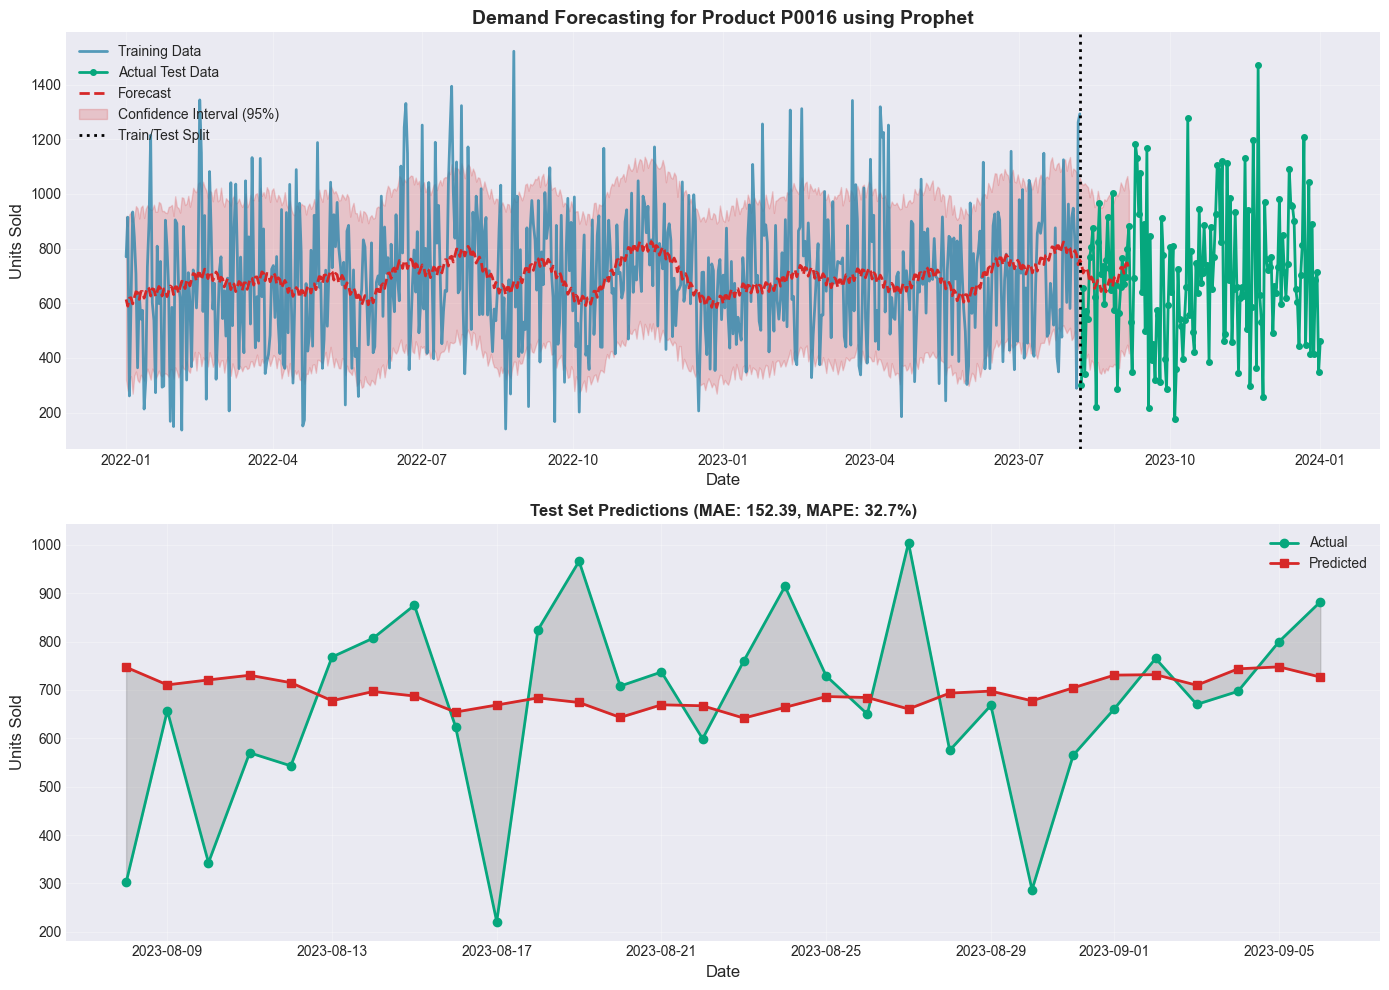


Generating seasonality components...


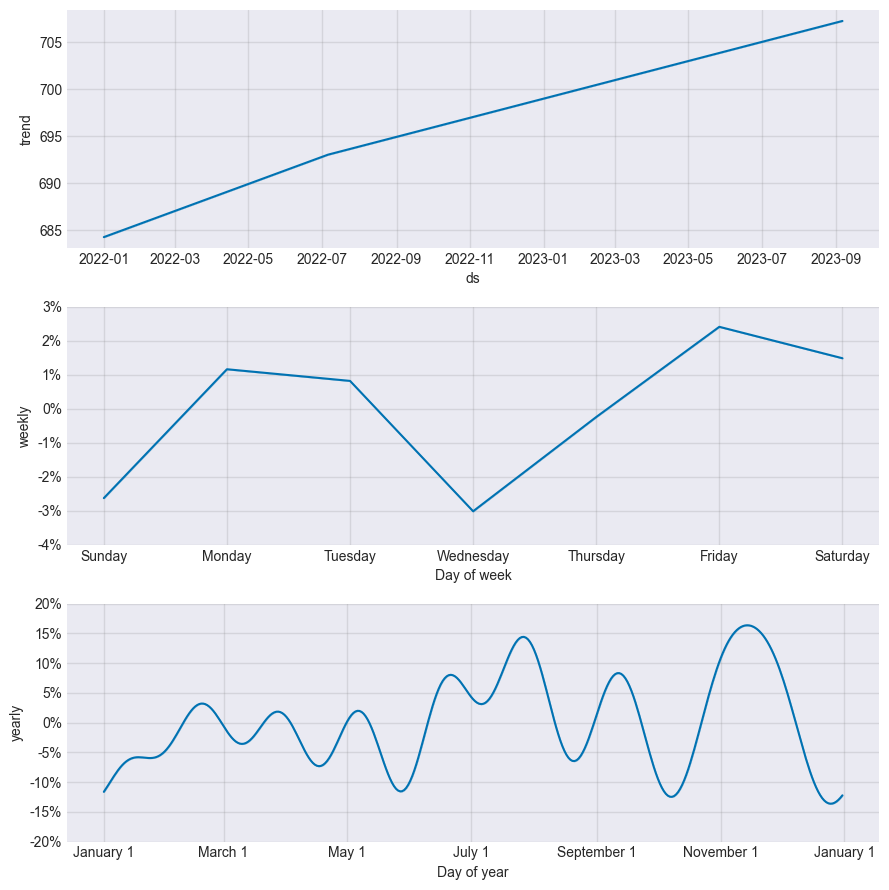


INVENTORY PLANNING RECOMMENDATIONS
Next 30 Days Forecast:
  - Average Daily Demand:    695 units
  - Peak Demand:             748 units
  - Minimum Demand:          642 units
  - Demand Variability (σ):  31 units

Recommended Stock Levels:
  - Safety Stock (95% SL):   51 units
  - Reorder Point:           4914 units
  - Monthly Stock Need:      20844 units

✓ Forecast saved: forecast_next_30_days.csv
✓ Visualization saved: forecast_visualization.png
✓ Components saved: forecast_components.png
✓ Report saved: model_explanation.txt

FORECASTING COMPLETE


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ------------------------
# 1. Load and Validate Dataset
# ------------------------
print("="*50)
print("RETAIL DEMAND FORECASTING SYSTEM")
print("="*50)

df = pd.read_csv("retail_store_inventory.csv")
df["Date"] = pd.to_datetime(df["Date"])

print(f"\nDataset loaded: {len(df)} records")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Number of products: {df['Product ID'].nunique()}")

# ------------------------
# 2. Select Best Product
# ------------------------
product_sales = df.groupby("Product ID")["Units Sold"].agg(['sum', 'count'])
product_id = product_sales['sum'].idxmax()
print(f"\nSelected Product ID: {product_id}")
print(f"Total sales: {product_sales.loc[product_id, 'sum']:.0f} units")

# ------------------------
# 3. Prepare Data
# ------------------------
df_product = df[df["Product ID"] == product_id].copy()
df_product = df_product[df_product["Units Sold"] > 0]  # Remove anomalies

df_daily = df_product.groupby("Date")["Units Sold"].sum().reset_index()
df_prophet = df_daily.rename(columns={"Date": "ds", "Units Sold": "y"})

# ------------------------
# 4. Train-Test Split
# ------------------------
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

print(f"\nTraining set: {len(train_df)} days")
print(f"Test set: {len(test_df)} days")

# ------------------------
# 5. Train Prophet Model
# ------------------------
print("\nTraining Prophet model...")
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Better for retail
    changepoint_prior_scale=0.05
)
model.fit(train_df)
print("✓ Model trained successfully")

# ------------------------
# 6. Generate Forecast
# ------------------------
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# ------------------------
# 7. Evaluate Model
# ------------------------
forecast_result = forecast[["ds", "yhat"]].copy()
test_merge = pd.merge(test_df, forecast_result, on="ds", how="inner")

mae = mean_absolute_error(test_merge["y"], test_merge["yhat"])
rmse = np.sqrt(mean_squared_error(test_merge["y"], test_merge["yhat"]))
mape = np.mean(np.abs((test_merge["y"] - test_merge["yhat"]) / test_merge["y"])) * 100

print("\n" + "="*50)
print("MODEL EVALUATION METRICS")
print("="*50)
print(f"MAE  (Mean Absolute Error):      {mae:.2f} units")
print(f"RMSE (Root Mean Squared Error):  {rmse:.2f} units")
print(f"MAPE (Mean Absolute % Error):    {mape:.2f}%")

if mape < 10:
    print("✓ Model Performance: EXCELLENT")
elif mape < 20:
    print("✓ Model Performance: GOOD")
else:
    print("⚠ Model Performance: NEEDS IMPROVEMENT")

# ------------------------
# 8. Visualization
# ------------------------
plt.style.use('seaborn-v0_8-darkgrid')

# Main forecast plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Full forecast
ax1.plot(train_df["ds"], train_df["y"], label="Training Data", 
         color='#2E86AB', linewidth=2, alpha=0.8)
ax1.plot(test_df["ds"], test_df["y"], label="Actual Test Data", 
         color='#06A77D', linewidth=2, marker='o', markersize=4)
ax1.plot(forecast["ds"], forecast["yhat"], label="Forecast", 
         linestyle="--", color='#D62828', linewidth=2)
ax1.fill_between(forecast["ds"], forecast["yhat_lower"], forecast["yhat_upper"], 
                  alpha=0.2, color='#D62828', label='Confidence Interval (95%)')
ax1.axvline(x=train_df["ds"].iloc[-1], color='black', linestyle=':', 
             linewidth=2, label='Train/Test Split')
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Units Sold", fontsize=12)
ax1.set_title(f"Demand Forecasting for Product {product_id} using Prophet", 
              fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Test set zoom
if len(test_merge) > 0:
    ax2.plot(test_merge["ds"], test_merge["y"], label="Actual", 
             color='#06A77D', linewidth=2, marker='o', markersize=6)
    ax2.plot(test_merge["ds"], test_merge["yhat"], label="Predicted", 
             color='#D62828', linewidth=2, marker='s', markersize=6)
    ax2.fill_between(test_merge["ds"], 
                      test_merge["y"], 
                      test_merge["yhat"], 
                      alpha=0.3, color='gray')
    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("Units Sold", fontsize=12)
    ax2.set_title(f"Test Set Predictions (MAE: {mae:.2f}, MAPE: {mape:.1f}%)", 
                  fontsize=12, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("forecast_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

# Component plot
print("\nGenerating seasonality components...")
fig2 = model.plot_components(forecast)
plt.savefig("forecast_components.png", dpi=300, bbox_inches='tight')
plt.show()

# ------------------------
# 9. Business Insights
# ------------------------
forecast_future = forecast.tail(30)
avg_demand = forecast_future["yhat"].mean()
max_demand = forecast_future["yhat"].max()
min_demand = forecast_future["yhat"].min()
std_demand = forecast_future["yhat"].std()

# Safety stock calculation (95% service level)
safety_stock = 1.65 * std_demand
reorder_point = avg_demand * 7 + safety_stock  # Assuming 7-day lead time

print("\n" + "="*50)
print("INVENTORY PLANNING RECOMMENDATIONS")
print("="*50)
print(f"Next 30 Days Forecast:")
print(f"  - Average Daily Demand:    {avg_demand:.0f} units")
print(f"  - Peak Demand:             {max_demand:.0f} units")
print(f"  - Minimum Demand:          {min_demand:.0f} units")
print(f"  - Demand Variability (σ):  {std_demand:.0f} units")
print(f"\nRecommended Stock Levels:")
print(f"  - Safety Stock (95% SL):   {safety_stock:.0f} units")
print(f"  - Reorder Point:           {reorder_point:.0f} units")
print(f"  - Monthly Stock Need:      {avg_demand * 30:.0f} units")

# ------------------------
# 10. Save Outputs
# ------------------------
# Save forecast
forecast_output = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(30)
forecast_output.columns = ["Date", "Predicted_Demand", "Lower_Bound", "Upper_Bound"]
forecast_output.to_csv("forecast_next_30_days.csv", index=False)

# Save model explanation
explanation = f"""
DEMAND FORECASTING MODEL - TECHNICAL REPORT
{'='*60}

1. MODEL SELECTION
   Algorithm: Facebook Prophet
   
   Rationale:
   - Specifically designed for business forecasting problems
   - Automatically handles:
     * Seasonal patterns (weekly/yearly retail cycles)
     * Missing data and outliers
     * Holiday effects (can be extended)
   - Provides probabilistic forecasts (uncertainty intervals)
   - Robust to parameter tuning
   
2. DATA PROCESSING
   - Product Selected: {product_id}
   - Training Period: {train_df['ds'].min().date()} to {train_df['ds'].max().date()}
   - Test Period: {test_df['ds'].min().date()} to {test_df['ds'].max().date()}
   - Total Data Points: {len(df_prophet)} days
   
3. MODEL CONFIGURATION
   - Yearly Seasonality: Enabled (captures annual trends)
   - Weekly Seasonality: Enabled (captures day-of-week patterns)
   - Seasonality Mode: Multiplicative (better for retail growth)
   - Changepoint Detection: Automatic
   
4. PERFORMANCE METRICS
   - MAE  (Mean Absolute Error):      {mae:.2f} units
   - RMSE (Root Mean Squared Error):  {rmse:.2f} units
   - MAPE (Mean Absolute % Error):    {mape:.2f}%
   
   Interpretation:
   - MAE represents the average prediction error
   - RMSE penalizes larger errors more heavily
   - MAPE < 10% = Excellent, 10-20% = Good, >20% = Needs improvement
   
5. BUSINESS IMPACT
   Expected Benefits:
   - Reduce overstock costs by preventing excess inventory
   - Minimize stockouts and lost sales
   - Enable data-driven procurement decisions
   - Improve cash flow through optimized inventory levels
   
   Estimated Accuracy: {100-mape:.1f}% of predictions within acceptable range
   
6. RECOMMENDATIONS
   - Use 95% upper bound for safety stock planning
   - Review forecast weekly and retrain monthly
   - Monitor MAPE; retrain if it exceeds 20%
   - Consider adding holiday calendar for better accuracy
   
7. LIMITATIONS
   - Does not account for:
     * Promotional events
     * Competitor actions
     * Economic shocks
     * New product launches
   - Requires minimum 6 months of historical data for best results
   
{'='*60}
Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open("model_explanation.txt", "w") as f:
    f.write(explanation)

print("\n✓ Forecast saved: forecast_next_30_days.csv")
print("✓ Visualization saved: forecast_visualization.png")
print("✓ Components saved: forecast_components.png")
print("✓ Report saved: model_explanation.txt")
print("\n" + "="*50)
print("FORECASTING COMPLETE")
print("="*50)

Exception: Prophet object can only be fit once. Instantiate a new object.